# EMG Controlled Adaptive Wearable Robotic Exoskeleton for Upper Limb Rehabilitation Using AI

# GRU .......

### Check the GPU workig for model training.

In [1]:
import keras
import tensorflow as tf
# Avoid OOM errors by setting GPU Memory Consumption Growth
   
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## First Method...

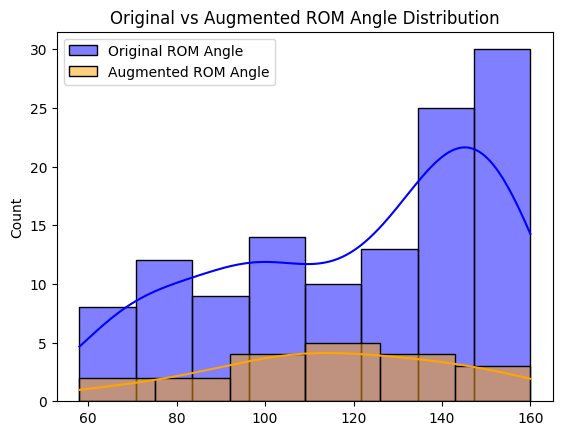

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tsaug import AddNoise, TimeWarp, Drift
import matplotlib.pyplot as plt
import seaborn as sns


# Load and prepare data
file_path = '../New_Data/Final_Dataset.xlsx'
data_01 = pd.read_excel(file_path)
Data = data_01.loc[:, 'ROM_angle':90].values

# Extract Min and Max ROM angle from the original data
rom_angle_min = Data[:, 0].min()
rom_angle_max = Data[:, 0].max()

# Function to constrain ROM angle within original Min and Max range
def constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max):
    augmented_sample[:, 0] = np.clip(augmented_sample[:, 0], rom_angle_min, rom_angle_max)
    return augmented_sample

# Augmentation pipeline
augmenter = (
    TimeWarp(n_speed_change=1, max_speed_ratio=1.2) +
    AddNoise(scale=0.005) +
    Drift(max_drift=0.01, n_drift_points=2)
)

# Generate exactly 20 augmented samples for the entire dataset
augmented_samples = []
for _ in range(20):  # Generate 20 samples
    sampled_rows = Data[np.random.choice(Data.shape[0], size=1, replace=False)]
    augmented_sample = augmenter.augment(sampled_rows)
    augmented_sample = constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max)
    augmented_samples.append(augmented_sample)

# Combine augmented samples into a single array
augmented_samples = np.vstack(augmented_samples)

# Combine original and augmented data
augmented_dataset = np.vstack([Data, augmented_samples])

# Check original and augmented ROM angle distributions
sns.histplot(Data[:, 0], label='Original ROM Angle', kde=True, color='blue')
sns.histplot(augmented_samples[:, 0], label='Augmented ROM Angle', kde=True, color='orange')
plt.legend()
plt.title('Original vs Augmented ROM Angle Distribution')
plt.show()


In [4]:
# Prepare the dataset
X = augmented_dataset[:, 1:]
y = augmented_dataset[:, 0]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Normalize target
y_max, y_min = y.max(), y.min()
y = (y - y_min) / (y_max - y_min)

# Reshape for LSTM input
time_steps = 5
if X_normalized.shape[1] % time_steps != 0:
    n_features = (X_normalized.shape[1] // time_steps) * time_steps
    X_normalized = X_normalized[:, :n_features]
X_reshaped = X_normalized.reshape(X_normalized.shape[0], time_steps, -1)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [5]:
print(f"Train : {X_train.shape[0]}  \nValidation : {X_val.shape[0]} \nTest : {X_test.shape[0]}")

Train : 98  
Validation : 21 
Test : 22


## Model Arrangement of the Neural Network...

| Layer                  | Parameters               | Additional Details                     |
|------------------------|--------------------------|----------------------------------------|
| **Conv1D**            | 32 filters, kernel size=3 | Activation: ReLU, Input shape: (X_reshaped.shape[1], X_reshaped.shape[2]) |
| **MaxPooling1D**       | Pool size=2              | -                                      |
| **GRU**               | 64 units                | Return sequences: True                 |
| **Dropout**            | Dropout rate=0.3         | -                                      |
| **GRU**               | 32 units                | Return sequences: False                |
| **Dropout**            | Dropout rate=0.2         | -                                      |
| **Dense**              | 1 unit                  | Regularisation: l2(0.001)              |


In [6]:
# Model definition
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l2(0.001))
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=['mae','mse', RootMeanSquaredError()]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/150
7/7 [==============================] - 5s 171ms/step - loss: 0.2013 - mae: 0.5553 - mse: 0.3994 - root_mean_squared_error: 0.6320 - val_loss: 0.0955 - val_mae: 0.3984 - val_mse: 0.1873 - val_root_mean_squared_error: 0.4327 - lr: 0.0010
Epoch 2/150
7/7 [==============================] - 0s 13ms/step - loss: 0.0489 - mae: 0.2511 - mse: 0.0940 - root_mean_squared_error: 0.3066 - val_loss: 0.0156 - val_mae: 0.1235 - val_mse: 0.0273 - val_root_mean_squared_error: 0.1653 - lr: 0.0010
Epoch 3/150
7/7 [==============================] - 0s 13ms/step - loss: 0.0248 - mae: 0.1678 - mse: 0.0458 - root_mean_squared_error: 0.2141 - val_loss: 0.0330 - val_mae: 0.1909 - val_mse: 0.0622 - val_root_mean_squared_error: 0.2493 - lr: 0.0010
Epoch 4/150
7/7 [==============================] - 0s 14ms/step - loss: 0.0280 - mae: 0.1772 - mse: 0.0521 - root_mean_squared_error: 0.2283 - val_loss: 0.0125 - val_mae: 0.1062 - val_mse: 0.0213 - val_root_mean_squared_error: 0.1459 - lr: 0.0010
Epoch 5/150

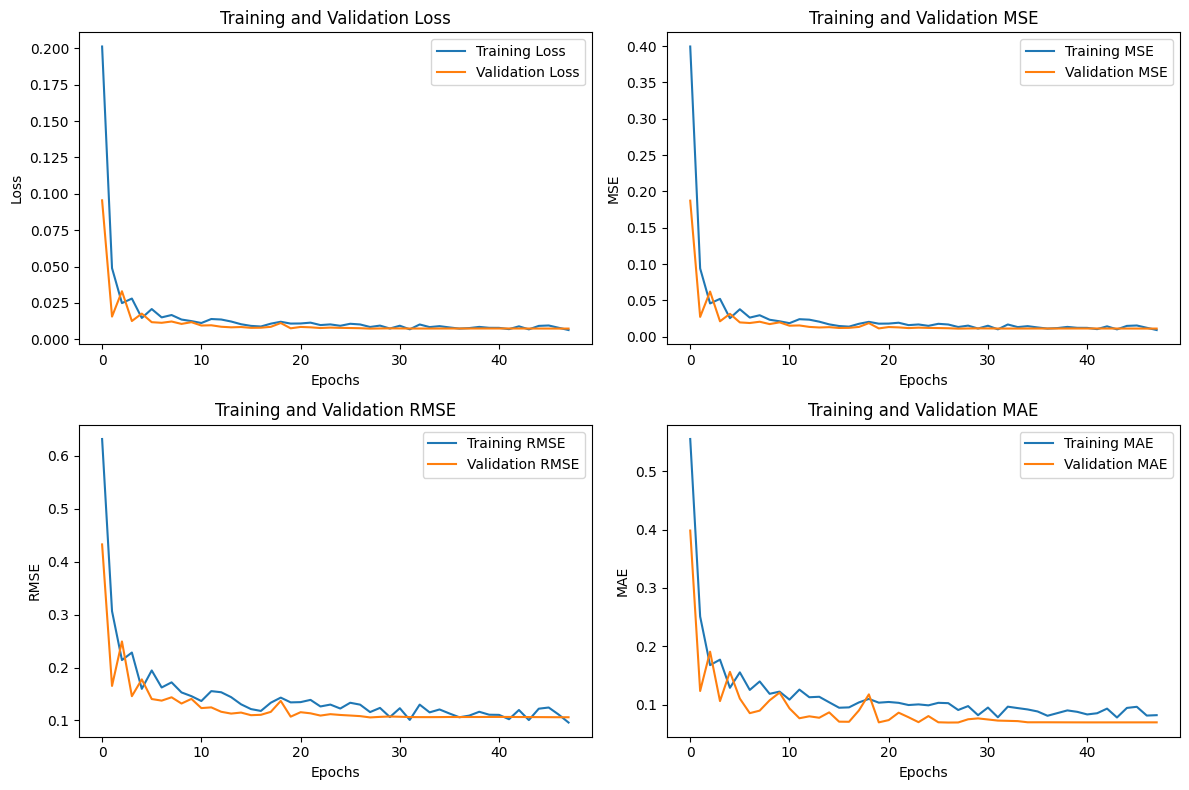


Final Metrics:
R2 Score: 89.41%
MAE: 7.09081
MSE: 85.88259
RMSE: 9.26729
Test Accuracy (based on MAPE): 93.24%


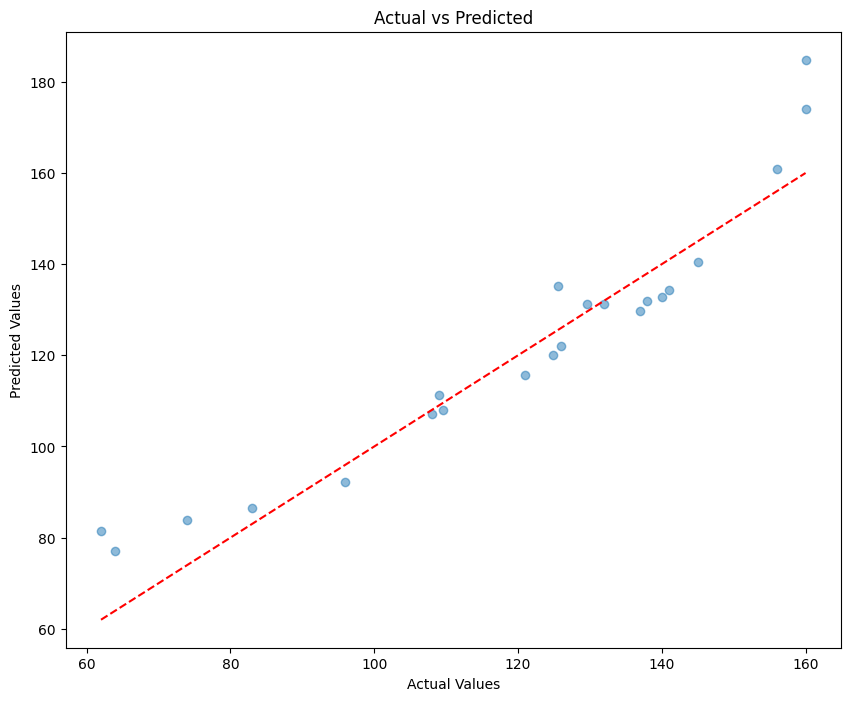

In [7]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
predictions = model.predict(X_test)
inv_pred = predictions * (y_max - y_min) + y_min
inv_y_test = y_test * (y_max - y_min) + y_min

# Metrics
mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
test_accuracy = 100 - mape  # Higher accuracy corresponds to lower error
r2 = r2_score(inv_y_test, inv_pred)
mae = mean_absolute_error(inv_y_test, inv_pred)
mse = mean_squared_error(inv_y_test, inv_pred)
rmse = np.sqrt(mse)

# Results
print("\nFinal Metrics:")
print(f'R2 Score: {r2 * 100:.2f}%')
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(inv_y_test, inv_pred, alpha=0.5)
plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Save the model
# model.save('Saved_Models/cnn_lstm_emg_model.h5')